## Разведочный анализ данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Список мест отбора проб
locations = {
    'д. Клятле': [55.539306, 051.856451],
    'ул. Ахтубинская, 4б': [55.622944, 051.825578],
    'ул. Гагарина, 32': [55.650091, 051.852687],
    'ул. Юбилейная, 3': [55.598983, 051.771936],
    'ул. Южная, 3': [55.613193, 051.784821],
    'ул. Ямьле, 20': [55.654578, 051.800072]
}

In [3]:
point1 = pd.read_excel('../data/raw/Усредненные_данные_Нижнекамск_т.1.xlsx')
point1

,Интервал отбора,Место отбора:,"Нижнекамск ➔ д. Клятле\n(координаты: широта - 55,539306, долгота - 051,856451)",Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,NaN,Показатель:,"CO, мг/м³","NO, мг/м³","NO2, мг/м³","NH3, мг/м³","SO2, мг/м³","H2S, мг/м³","T внеш., °C","V ветра, м/с","D ветра, °","H внеш., %","P атм., мм.рт.ст.","R осадк., мм/ч"
1,NaN,ПДК м.р.:,5,0.4,0.2,0.2,0.5,0.008,-,-,-,-,-,-
2,NaN,Изм. оборуд.:,К-100,Н-320А,Н-320А,Н-320А,СВ-320-А2,СВ-320-А2,Vantage Pro 2,Vantage Pro 2,Vantage Pro 2,Vantage Pro 2,Vantage Pro 2,Vantage Pro 2
3,01.06.2023 00:00,NaN,"0,2","0,001","0,001","0,014","0,003","0,0004","16,8","<0,5 (0,2)",106 (В),83,"745,1","0,0"
4,01.06.2023 00:30,NaN,"0,2","0,002","0,001","0,014","0,003","0,0004","15,8","<0,5 (0,3)",106 (В),85,"745,1","0,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,29.06.2023 21:30,NaN,"0,0","0,001","0,004","0,014","0,003","0,0002","19,5","0,6",126 (Ю-В),60,"746,6","0,0"
1391,29.06.2023 22:00,NaN,"0,0","0,000","0,005","0,015","0,004","0,0003","19,2","0,7",126 (Ю-В),60,"746,5","0,0"
1392,29.06.2023 22:30,NaN,"0,0","0,001","0,004","0,014","0,004","0,0003","19,4","1,2",118 (Ю-В),56,"746,3","0,0"
1393,29.06.2023 23:00,NaN,"0,0","0,001","0,004","0,014","0,005","0,0004","19,7","1,2",117 (Ю-В),55,"746,2","0,0"


In [4]:
# Сохраним значения ПДК
threshold = dict(zip(point1.iloc[0, 2:].values, point1.iloc[0:2, 2:].iloc[1].values))
threshold['NO2, мг/м³']

0.2

In [5]:
indexes = list(point1.loc[0])
indexes = indexes[2:]
indexes

['CO, мг/м³',
 'NO, мг/м³',
 'NO2, мг/м³',
 'NH3, мг/м³',
 'SO2, мг/м³',
 'H2S, мг/м³',
 'T внеш., °C',
 'V ветра, м/с',
 'D ветра, °',
 'H внеш., %',
 'P атм., мм.рт.ст.',
 'R осадк., мм/ч']

In [6]:
point1 = point1.loc[3:].drop(columns=['Место отбора:']).set_index('Интервал отбора')
point1.columns = indexes
point1 = point1.apply(lambda x: x.str.replace(',', '.'))
point1.head()

,"CO, мг/м³","NO, мг/м³","NO2, мг/м³","NH3, мг/м³","SO2, мг/м³","H2S, мг/м³","T внеш., °C","V ветра, м/с","D ветра, °","H внеш., %","P атм., мм.рт.ст.","R осадк., мм/ч"
Интервал отбора,,,,,,,,,,,,
01.06.2023 00:00,0.2,0.001,0.001,0.014,0.003,0.0004,16.8,<0.5 (0.2),106 (В),83,745.1,0.0
01.06.2023 00:30,0.2,0.002,0.001,0.014,0.003,0.0004,15.8,<0.5 (0.3),106 (В),85,745.1,0.0
01.06.2023 01:00,0.2,0.002,0.002,0.014,0.002,0.0006,15.3,<0.5 (0.1),107 (В),87,745.0,0.0
01.06.2023 01:30,0.2,0.002,0.001,0.014,0.003,0.0005,14.8,<0.5 (0.0),Ш,88,745.1,0.0
01.06.2023 02:00,0.2,0.002,0.001,0.015,0.003,0.0005,15.2,<0.5 (0.4),134 (Ю-В),90,745.2,0.0


In [7]:
# Функция для преобразования формата скорости ветра
def extract_value(value):
    if isinstance(value, (int, float)):
        return value
    match = re.search(r'\((\d+\.\d+)\)', str(value))
    if match:
        return float(match.group(1))
    return value

point1['V ветра, м/с'] = point1['V ветра, м/с'].apply(extract_value)

In [8]:
# Сколько записей со штилем
#len(point1[point1["D ветра, °"] == 'Ш'])

In [9]:
# Разобъем столбец с направлением ветра на две колонки
point1[['Угол ветра, °', 'Направление ветра']] = point1['D ветра, °'].str.extract(r'(\d+)\s?\((.+)\)')
point1 = point1.drop(columns=['D ветра, °'])

# Штиль оказался NaN, вернем значение 'Ш'
point1['Направление ветра'].replace(np.NaN, 'Ш', inplace=True)

#point1['Угол ветра, °'] = pd.to_numeric(point1['Угол ветра, °'], errors='coerce')
#point1['Угол ветра, °'].replace(np.NaN, 'NA', inplace=True)

Из дальнейшего анализа будет понятно, что Штиль практически не оказывает влияния на повышение концентрации загрязителя. Это видно из feature importance и по ошибке MAE, которая не меняется при удалении из данных строк с 'Ш'. Но оставим записи со 'Ш', чтобы в будущем иметь возможность прогнозировать поступающий временной ряд со множеством 'Ш', а не удалять соответствующие периоды времени.

In [10]:
# Не используем
def assign_label(value):
    """Функция для более детальной разметки по 16 направлениям ветра"""
    
    # диапазоны углов ветра
    ranges = [
        0, 11.25, 33.75, 56.25,
        78.75, 101.25, 123.75, 146.25,
        168.75, 191.25, 213.75, 236.25,
        258.75, 281.25, 303.75, 326.25,
        348.75, 360
        ]
    # метки направлений ветра
    labels = [
        'С', 'С-С-В', 'С-В', 'В-С-В',
        'В', 'В-Ю-В', 'Ю-В', 'Ю-Ю-В',
        'Ю', 'Ю-Ю-З', 'Ю-З', 'З-Ю-З',
        'З', 'З-С-З', 'С-З', 'С-С-З',
        'С'
        ]
    if pd.notna(value):
        for i in range(len(ranges) - 1):
            if ranges[i] <= value < ranges[i + 1]:
                return labels[i]
    
    # None для пропущенных значений
    return None

# point1['Направление ветра'] = point1['Угол ветра, °'].apply(assign_label)

**Роза румбов**  
  
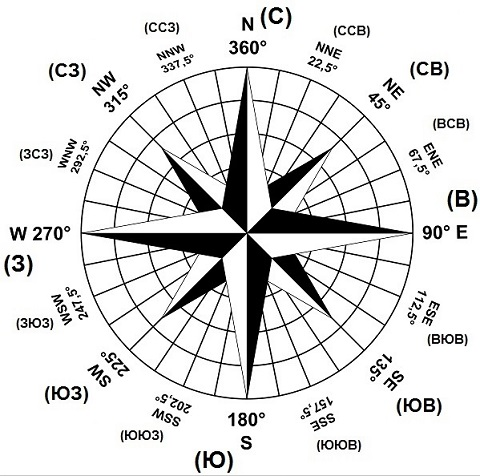

In [11]:
# Вариант обработки с указанием только есть ли ветер или штиль, без стороны света
# point1.loc[point1['Направление ветра'] == 'Ш', 'Направление ветра'] = True
# point1.loc[point1['Направление ветра'] != True, 'Направление ветра'] = False

In [12]:
point1.head()

,"CO, мг/м³","NO, мг/м³","NO2, мг/м³","NH3, мг/м³","SO2, мг/м³","H2S, мг/м³","T внеш., °C","V ветра, м/с","H внеш., %","P атм., мм.рт.ст.","R осадк., мм/ч","Угол ветра, °",Направление ветра
Интервал отбора,,,,,,,,,,,,,
01.06.2023 00:00,0.2,0.001,0.001,0.014,0.003,0.0004,16.8,0.2,83,745.1,0.0,106,В
01.06.2023 00:30,0.2,0.002,0.001,0.014,0.003,0.0004,15.8,0.3,85,745.1,0.0,106,В
01.06.2023 01:00,0.2,0.002,0.002,0.014,0.002,0.0006,15.3,0.1,87,745.0,0.0,107,В
01.06.2023 01:30,0.2,0.002,0.001,0.014,0.003,0.0005,14.8,0.0,88,745.1,0.0,NaN,Ш
01.06.2023 02:00,0.2,0.002,0.001,0.015,0.003,0.0005,15.2,0.4,90,745.2,0.0,134,Ю-В


In [13]:
# Оставшиеся пропуски заменим интерполяцией
for col in point1.columns:
    point1[col] = pd.to_numeric(point1[col], errors='ignore')
point1.interpolate(inplace=True)

In [14]:
point1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1392 entries, 01.06.2023 00:00 to 29.06.2023 23:30
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CO, мг/м³          1392 non-null   float64
 1   NO, мг/м³          1392 non-null   float64
 2   NO2, мг/м³         1392 non-null   float64
 3   NH3, мг/м³         1392 non-null   float64
 4   SO2, мг/м³         1392 non-null   float64
 5   H2S, мг/м³         1392 non-null   float64
 6   T внеш., °C        1392 non-null   float64
 7   V ветра, м/с       1392 non-null   float64
 8   H внеш., %         1392 non-null   int64  
 9   P атм., мм.рт.ст.  1392 non-null   float64
 10  R осадк., мм/ч     1392 non-null   float64
 11  Угол ветра, °      1392 non-null   float64
 12  Направление ветра  1392 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 152.2+ KB


In [15]:
point1.describe()

,"CO, мг/м³","NO, мг/м³","NO2, мг/м³","NH3, мг/м³","SO2, мг/м³","H2S, мг/м³","T внеш., °C","V ветра, м/с","H внеш., %","P атм., мм.рт.ст.","R осадк., мм/ч","Угол ветра, °"
count,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000
mean,0.123455,0.001148,0.005966,0.014414,0.053797,0.001132,16.122773,1.621121,58.694684,750.203448,0.007471,178.783046
std,0.162158,0.001763,0.007953,0.000924,0.070318,0.001168,5.334376,1.220588,17.462607,3.734952,0.142339,122.076692
min,0.000000,0.000000,0.000000,0.011000,0.000000,0.000000,4.200000,0.000000,25.000000,743.600000,0.000000,0.000000
25%,0.000000,0.000000,0.001000,0.014000,0.009000,0.000200,12.200000,0.500000,43.000000,747.600000,0.000000,71.750000
50%,0.100000,0.001000,0.003000,0.014000,0.023500,0.000700,15.900000,1.600000,58.000000,749.200000,0.000000,177.400000
75%,0.200000,0.001000,0.008000,0.015000,0.075000,0.001700,20.000000,2.500000,74.000000,751.600000,0.000000,301.000000
max,1.400000,0.032000,0.052000,0.035000,0.605000,0.005500,27.800000,7.200000,92.000000,760.400000,3.300000,360.000000


В первой локации ПДК превышалось только для SO2

## Визуализация

<Axes: >

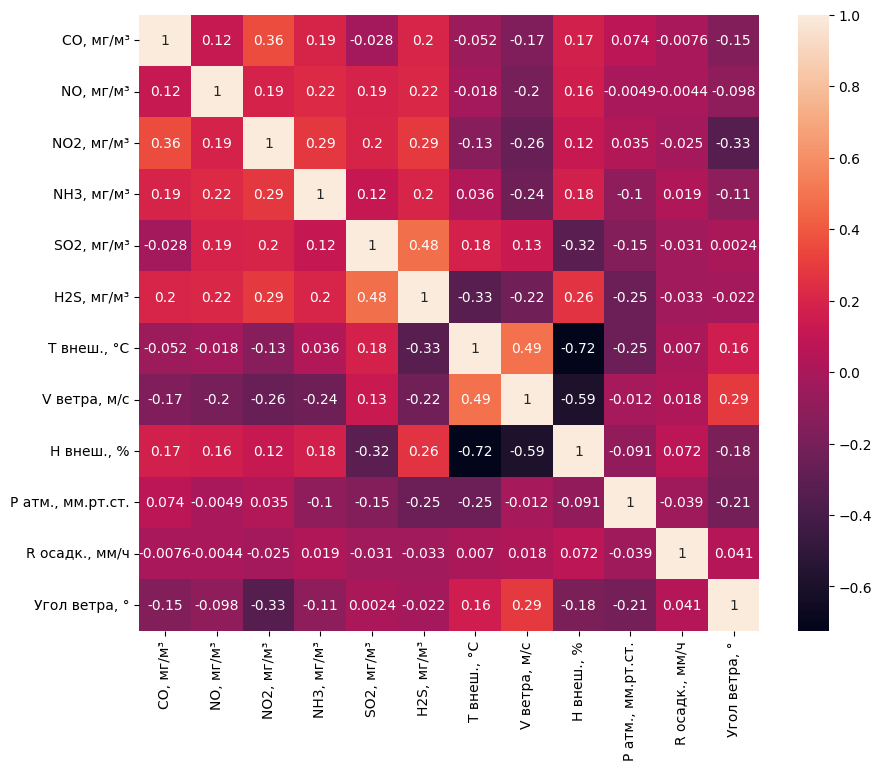

In [16]:
# Корреляции
plt.figure(figsize=(10,8))
sns.heatmap(point1.select_dtypes(include=['float64', 'int64']).corr(), annot=True)

Возможно выброс H2S и SO2 происходил совместно

<Figure size 1100x700 with 0 Axes>

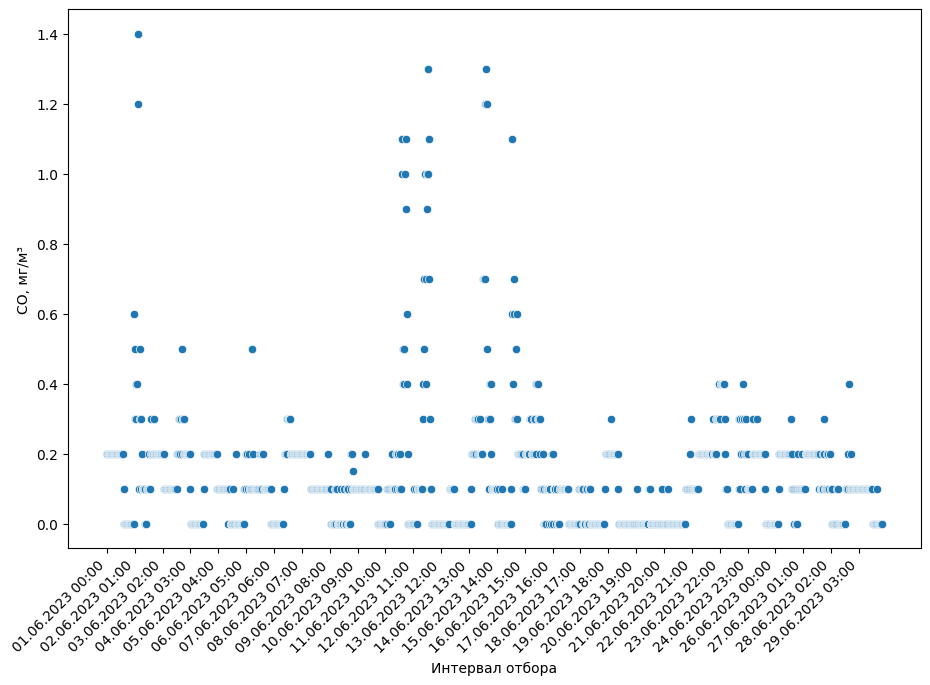

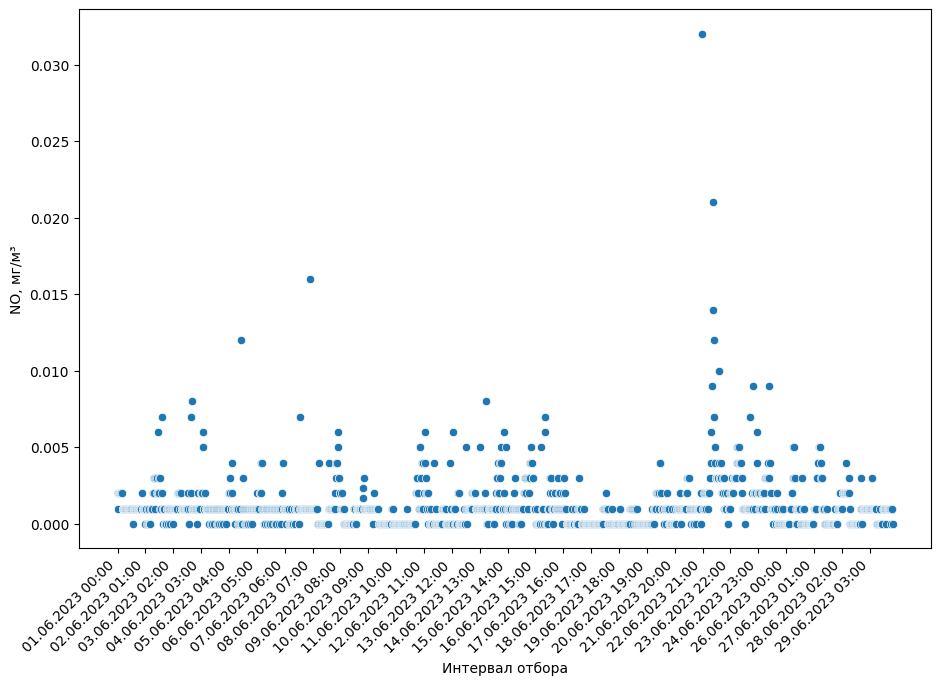

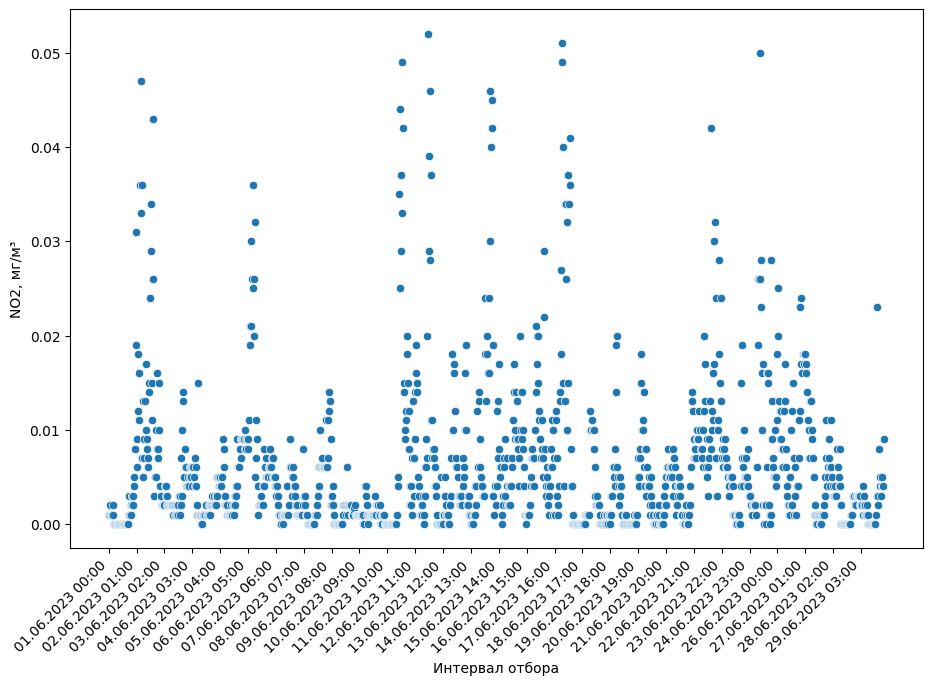

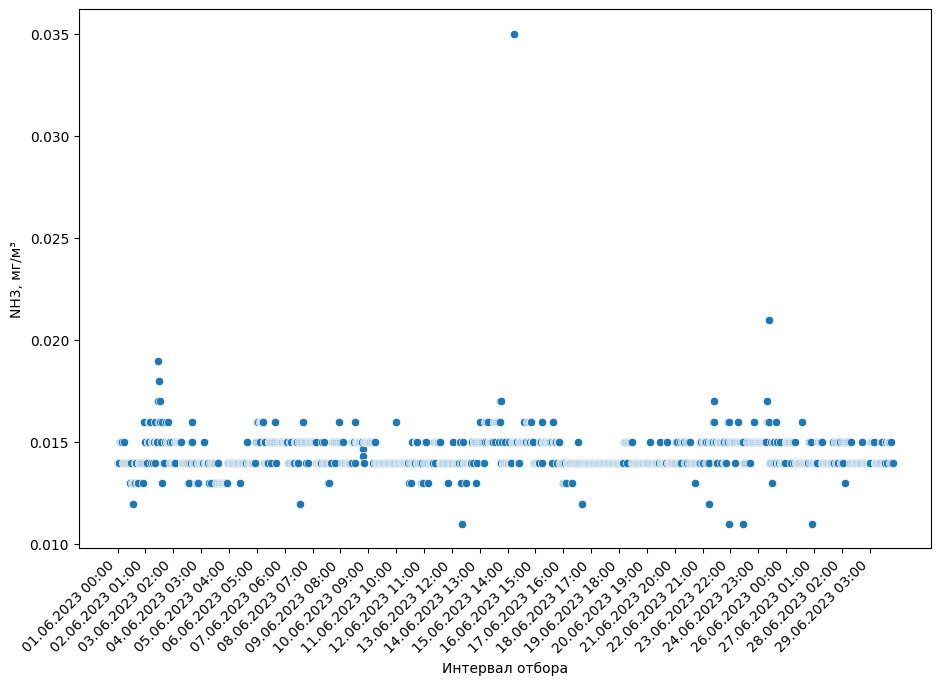

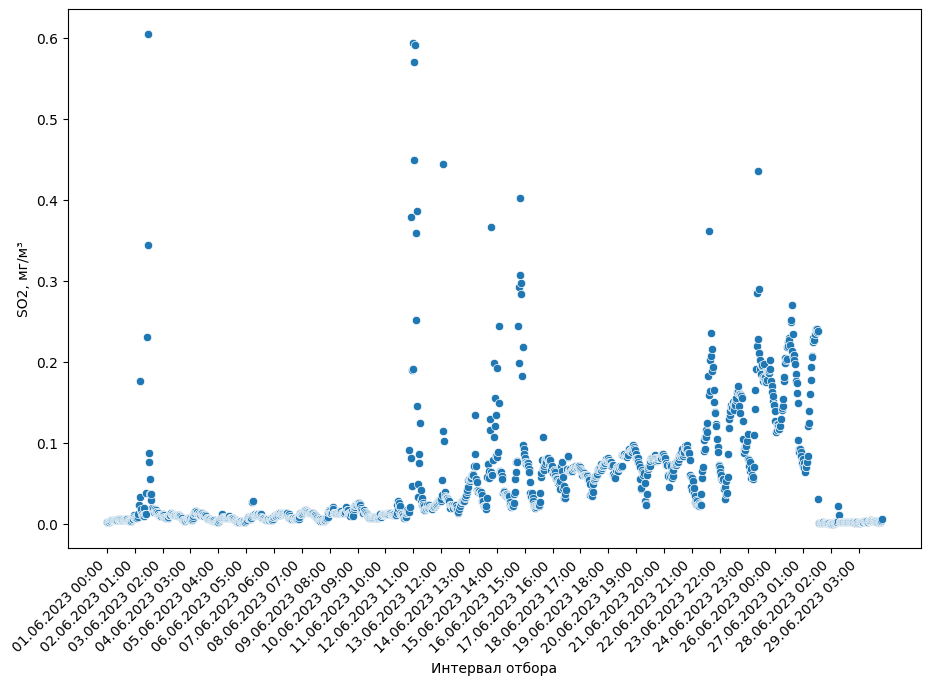

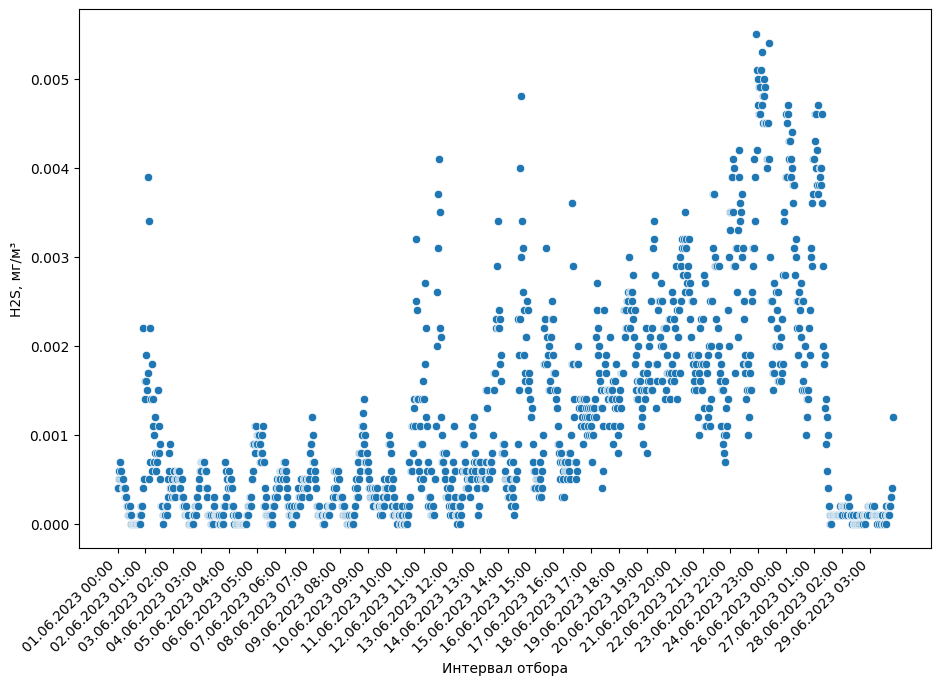

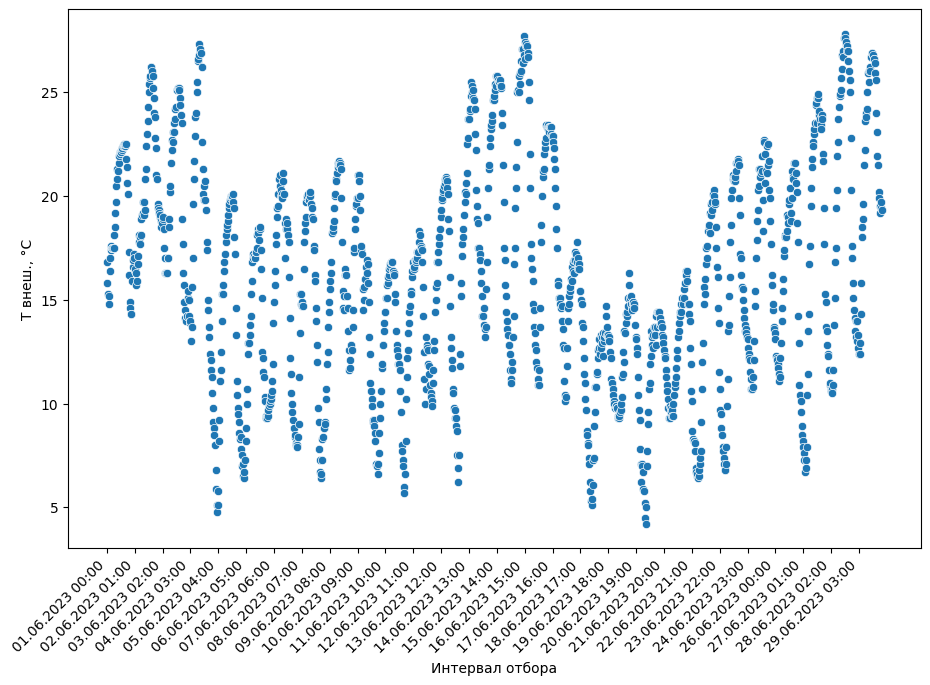

In [17]:
plt.figure(figsize=(11, 7))

for column in point1.columns[:7]:
    plt.figure(figsize=(11, 7))
    ax = sns.scatterplot(data=point1[column])

    x_labels = point1.index
    ax.set_xticks(x_labels[::50])
    ax.set_xticklabels(x_labels[::50], rotation=45, ha="right")

    plt.show()

In [18]:
del point1

## Подготовка данных для модели

В качестве начального приближения возьмем пока только одно из загрязняющих веществ и параметры ветра

In [19]:
# Функция загрузки и подготовки данных по нужным веществам из всех 6 геоточек

def load_data(num, substance):
    '''num - номер геоточки
       substance - название загрязняющего вещества
    '''
    
    point = pd.read_excel(f'../data/raw/Усредненные_данные_Нижнекамск_т.{num}.xlsx')
    indexes = list(point.loc[0])
    indexes = indexes[2:]

    point = point.loc[3:].drop(columns=['Место отбора:']).set_index('Интервал отбора')
    point.columns = indexes

    point = point.apply(lambda x: x.str.replace(',', '.'))

    point['V ветра, м/с'] = point['V ветра, м/с'].apply(extract_value)
    point[['Угол ветра, °', 'Направление ветра']] = point['D ветра, °'].str.extract(r'(\d+)\s?\((.+)\)')
    # 16 меток направлений ветра
    # point['Угол ветра, °'] = pd.to_numeric(point['Угол ветра, °'], errors='coerce')
    # point['Направление ветра'] = point['Угол ветра, °'].apply(assign_label)
    point['Направление ветра'].replace(np.NaN, 'Ш', inplace=True)
        
    columns = [substance, 'V ветра, м/с', 'Угол ветра, °', 'Направление ветра']
    point = point[columns]
    
    # Заполнение пропусков, если их в концентрациях не более 5%
    for col in point.columns:
        point[col] = pd.to_numeric(point[col], errors='ignore')
    if point[substance].isna().sum() / len(point) < 0.05:
        point.interpolate(inplace=True)
    
    return point

In [20]:
substance = 'NO2, мг/м³'

point1 = load_data(1, substance)
point2 = load_data(2, substance)
point3 = load_data(3, substance)
point4 = load_data(4, substance)
point5 = load_data(5, substance)
point6 = load_data(6, substance)

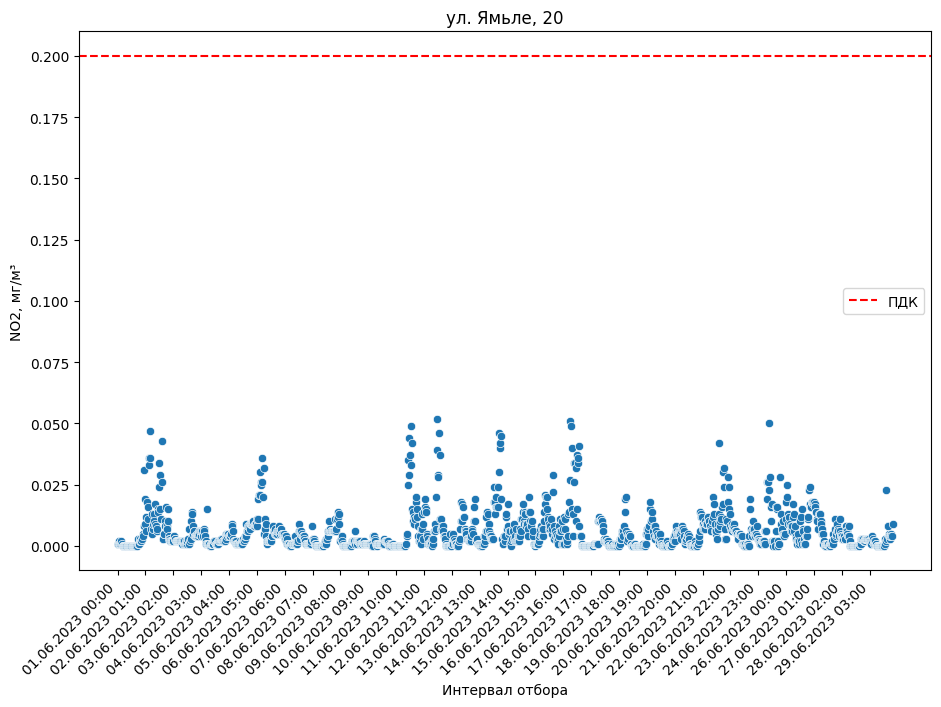

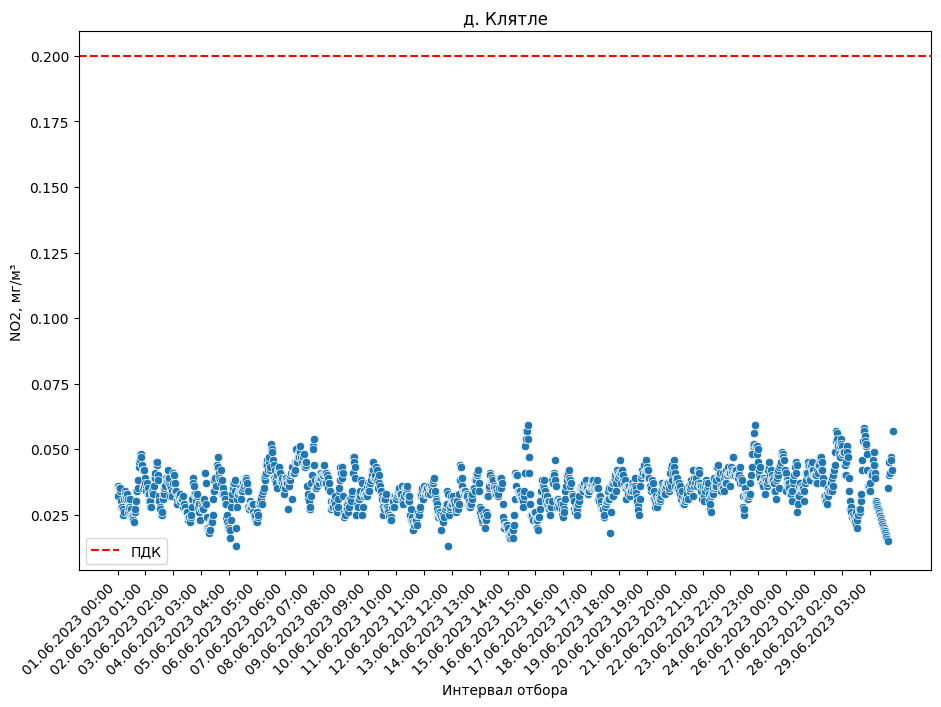

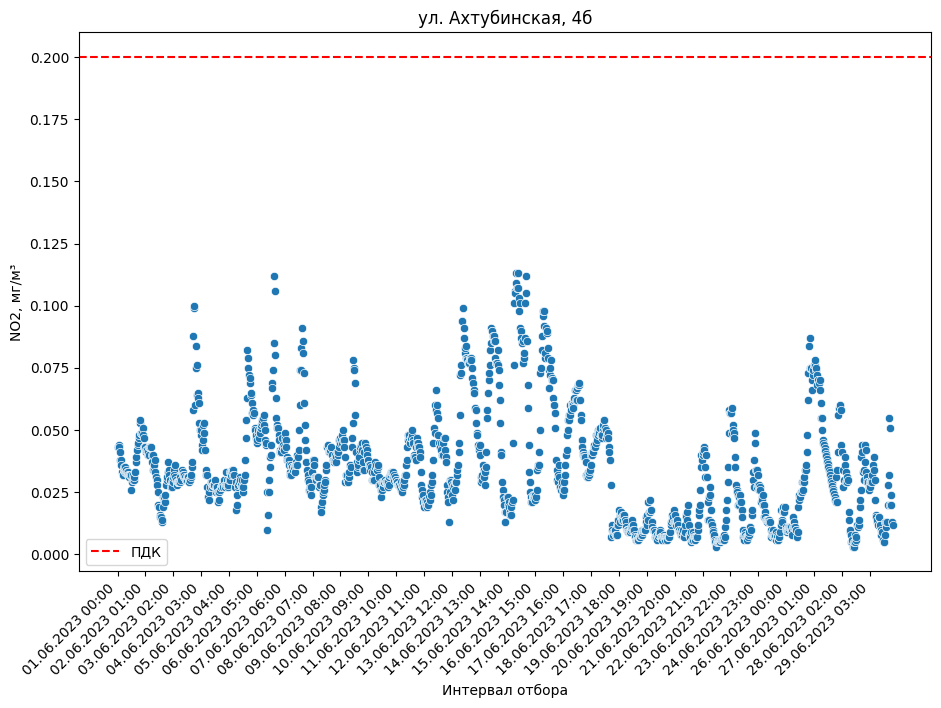

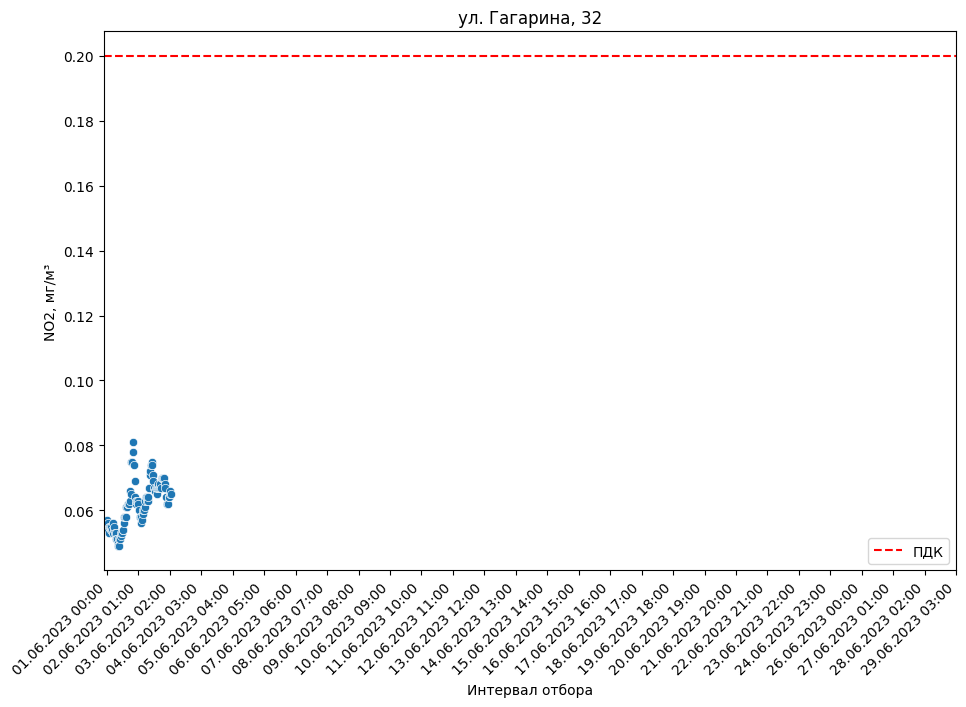

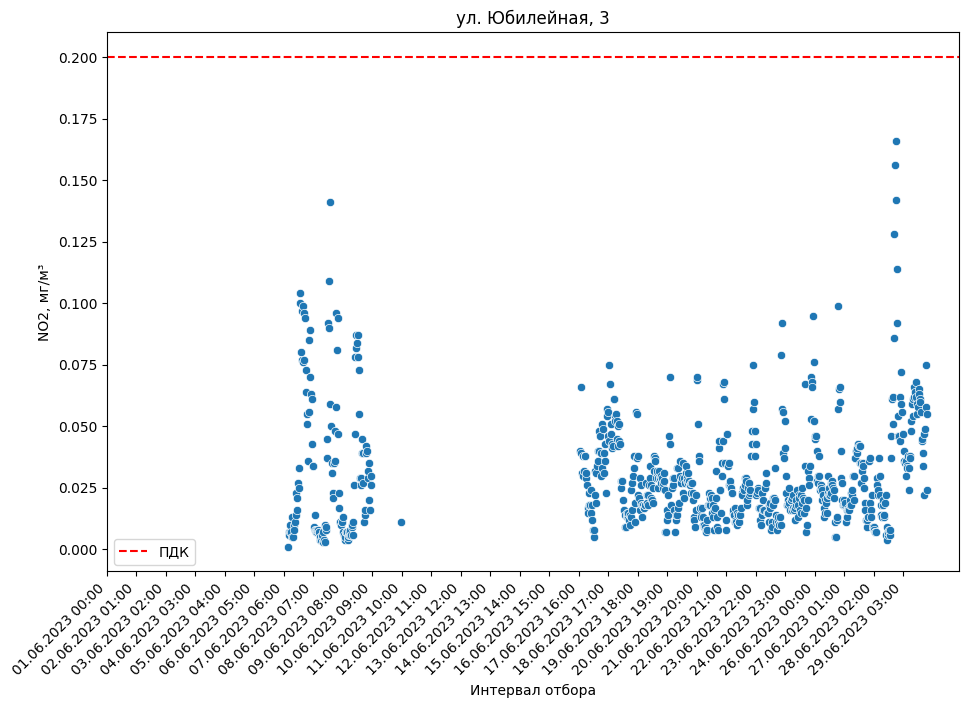

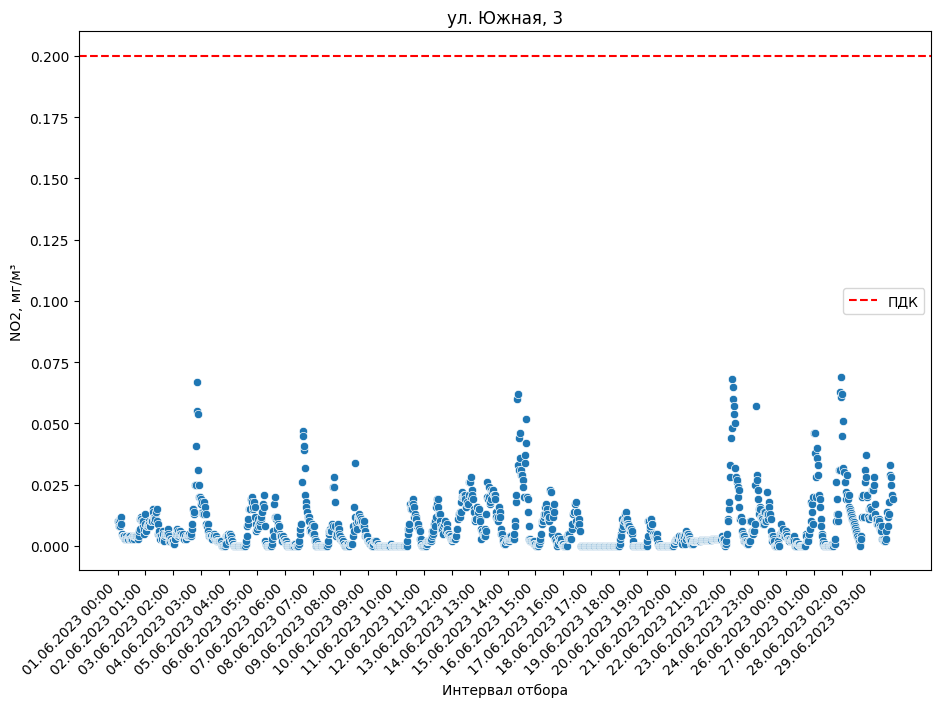

In [21]:
i = 0
for df in [point1, point2, point3, point4, point5, point6]:
    plt.figure(figsize=(11, 7))
    ax = sns.scatterplot(data=df[substance])

    x_labels = df.index
    ax.set_xticks(x_labels[::50])
    ax.set_xticklabels(x_labels[::50], rotation=45, ha="right")
    # уровень ПДК 
    ax.axhline(y=threshold[substance], color='r', linestyle='--', label='ПДК')
    
    plt.title(list(locations)[i - 1])
    i += 1
    plt.legend()
    plt.show()

In [22]:
plt.close()

Отложим последний датасет (point6), чтобы позднее сформировать из него данные по концентрациям в качестве целевой переменной.  
Будем добавлять признаки, зависящие от времени.
Можно экспериментировать как с количеством лагов ("глубиной взгляда в прошлое"), так и с количеством исходных параметров погодных услов.й

In [23]:
list(locations.values())

[[55.539306, 51.856451],
 [55.622944, 51.825578],
 [55.650091, 51.852687],
 [55.598983, 51.771936],
 [55.613193, 51.784821],
 [55.654578, 51.800072]]

In [24]:
from geopy.distance import geodesic

def make_df(df, num):
    '''Функция предобработки датасета с предикторами
       num - номер геоточки
    '''

    coor = list(locations.values())[num - 1]
    target_coor = list(locations.values())[5]

    df = df.copy()
    df.dropna(inplace=True)
    df['lat'], df['lon'] = coor

    # Добавим расстояние от данной точки до точки 6 в качестве входной переменной
    df['distance, km'] = geodesic(coor, target_coor).km
    
    # Фичи c временными лагам
    for i in range(1, 6):
        df[f"V ветра_{i}"] = df['V ветра, м/с'].shift(i)
        df[f"Угол ветра_{i}"] = df['Угол ветра, °'].shift(i)
        df[f"{substance}_{i}"] = df[substance].shift(i)
    df.dropna(inplace=True)

    return df

In [25]:
X1 = make_df(point1, 1)
X2 = make_df(point2, 2)
X3 = make_df(point3, 3)
X4 = make_df(point4, 4)
X5 = make_df(point5, 5)
print(X1.shape)
print(X2.shape)
print(X3.shape)
print(X4.shape)
print(X5.shape)

X = pd.concat([X1, X2, X3, X4, X5], axis=0)

(1387, 22)
(1387, 22)
(1387, 22)
(86, 22)
(596, 22)


In [26]:
# Кодирование категорий
X = pd.get_dummies(X, columns=['Направление ветра'])
X.shape

(4843, 30)

In [27]:
# Целевая переменная
X['target_C, мг/м³'] = point6[substance].reindex(X.index)
X.dropna(inplace=True)   # на всякий случай

y = X.pop('target_C, мг/м³')

print(X.shape)
print(y.shape)

(4843, 30)
(4843,)


In [28]:
# Проверка на дубликаты
dupl = X.loc[X.duplicated()]
len(dupl)

0

## Исследование моделей

### С перемешиванием

In [29]:
# Разбиваем
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)

# Масштабируем
scl = StandardScaler()
scl.fit(X_train)
X_train_scl = scl.transform(X_train)
X_test_scl = scl.transform(X_test)

(3390, 30)
(1453, 30)
(1453,)
(3390,)


#### Random Forest

In [30]:
rf = RandomForestRegressor(random_state=1)
rf.fit(X_train_scl, y_train)

RandomForestRegressor(random_state=1)

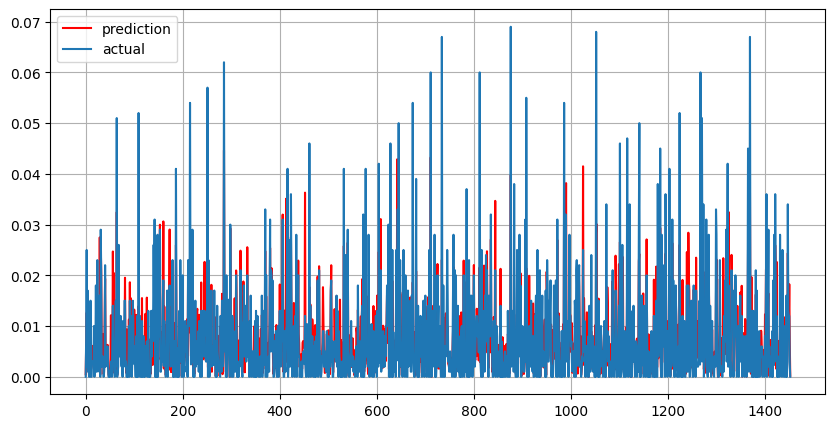

In [31]:
pred = rf.predict(X_test_scl)

plt.figure(figsize=(10, 5))
plt.plot(pred, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")

In [32]:
print((pred < 0).sum(), 'отрицательных значений заменены на 0')
pred[pred < 0] = 0

0 отрицательных значений заменены на 0


In [33]:
'MAE =', mean_absolute_error(pred, y_test)

('MAE =', 0.0036931874741913287)

In [34]:
pd.DataFrame(rf.feature_importances_, index=list(X),
             columns=['Importance']).sort_values(by='Importance').tail()

,Importance
V ветра_5,0.072644
V ветра_2,0.081514
"Угол ветра, °",0.085959
Угол ветра_1,0.086839
V ветра_4,0.110589


#### CatBoost

In [35]:
cb = CatBoostRegressor(n_estimators=300)
cb.fit(X_train_scl, y_train)

Learning rate set to 0.132145
0:	learn: 0.0092948	total: 193ms	remaining: 57.6s
1:	learn: 0.0088984	total: 196ms	remaining: 29.2s
2:	learn: 0.0085552	total: 200ms	remaining: 19.8s
3:	learn: 0.0082117	total: 203ms	remaining: 15s
4:	learn: 0.0079674	total: 207ms	remaining: 12.2s
5:	learn: 0.0077443	total: 210ms	remaining: 10.3s
6:	learn: 0.0075559	total: 213ms	remaining: 8.93s
7:	learn: 0.0074053	total: 217ms	remaining: 7.9s
8:	learn: 0.0072544	total: 220ms	remaining: 7.11s
9:	learn: 0.0071141	total: 223ms	remaining: 6.47s
10:	learn: 0.0070352	total: 226ms	remaining: 5.95s
11:	learn: 0.0069335	total: 230ms	remaining: 5.51s
12:	learn: 0.0068242	total: 233ms	remaining: 5.14s
13:	learn: 0.0067347	total: 236ms	remaining: 4.82s
14:	learn: 0.0066721	total: 239ms	remaining: 4.55s
15:	learn: 0.0066214	total: 243ms	remaining: 4.31s
16:	learn: 0.0065627	total: 246ms	remaining: 4.09s
17:	learn: 0.0064866	total: 249ms	remaining: 3.9s
18:	learn: 0.0064460	total: 253ms	remaining: 3.74s
19:	learn: 0.00

In [36]:
pred = cb.predict(X_test_scl)

print((pred < 0).sum(), 'отрицательных значений заменены на 0')
pred[pred < 0] = 0

61 отрицательных значений заменены на 0


MAE = 0.0037677261762365166



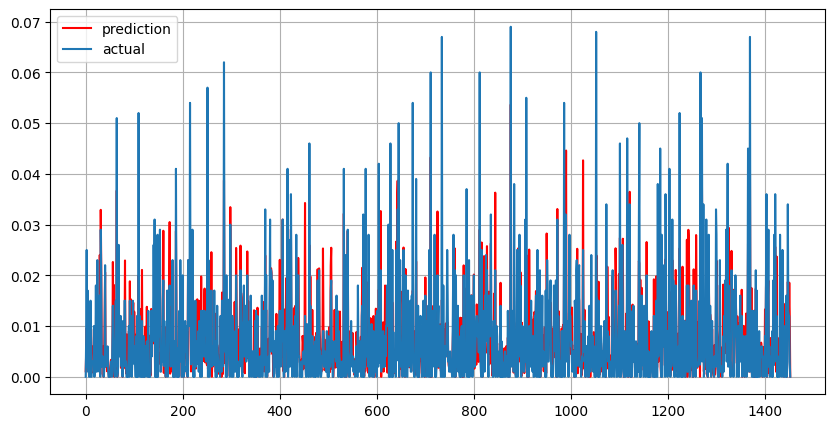

In [37]:
print('MAE =', mean_absolute_error(pred, y_test))
print()

plt.figure(figsize=(10, 5))
plt.plot(pred, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.show()

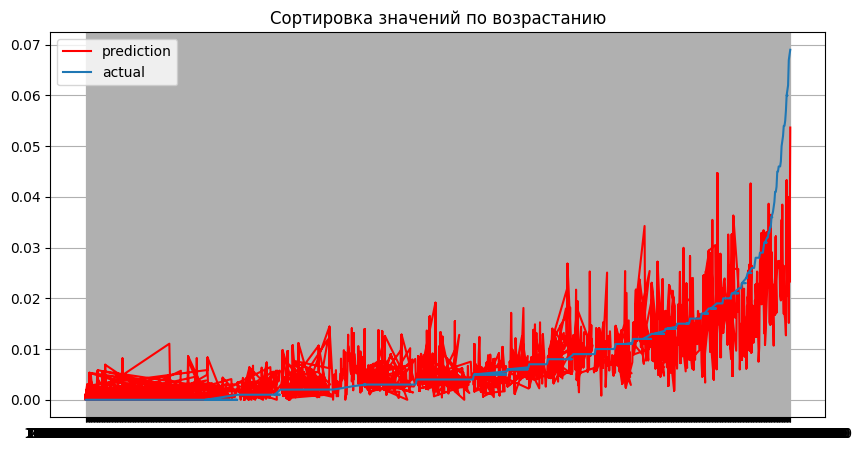

In [38]:
# Отсортируем фактические значения по возрастанию для визаулизации
pred = pd.Series(pred, index=y_test.index)
y_test_sorted = y_test.sort_values()
pred_sorted = pred.loc[y_test_sorted.index]

plt.figure(figsize=(10, 5))
plt.plot(pred_sorted, "r", label="prediction")
plt.plot(y_test_sorted, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title('Сортировка значений по возрастанию')
plt.show()

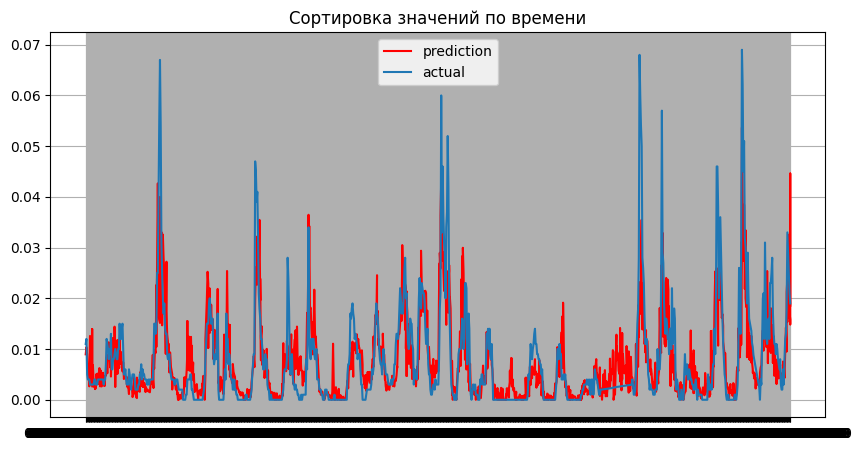

In [39]:
# Отсортируем фактические значения по времени
y_test_sorted = y_test.sort_index()
pred_sorted = pred.loc[y_test_sorted.index]

plt.figure(figsize=(10, 5))
plt.plot(pred_sorted, "r", label="prediction")
plt.plot(y_test_sorted, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title('Сортировка значений по времени')
plt.show()

Text(0.5, 1.0, 'Feature Importance')

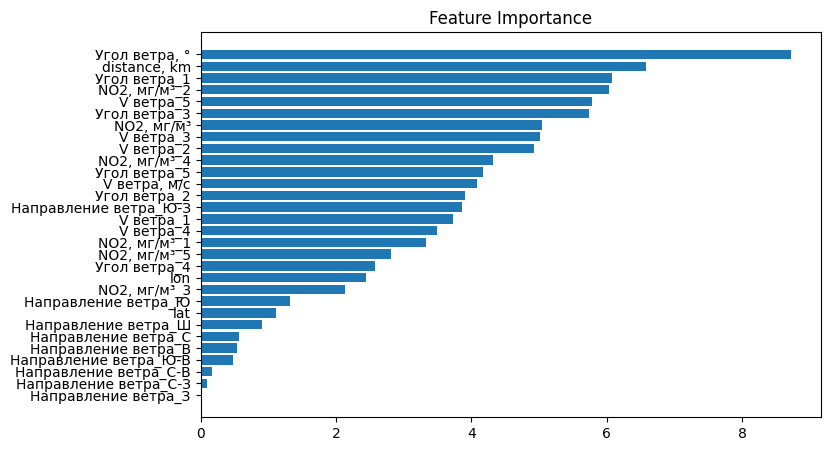

In [40]:
feature_importance = cb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(8, 5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

### Без перемешивания

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=False)

scl = StandardScaler()
scl.fit(X_train)
X_train_scl = scl.transform(X_train)
X_test_scl = scl.transform(X_test)

cb_no_shuffle = CatBoostRegressor(n_estimators=300)
cb_no_shuffle.fit(X_train_scl, y_train)
pred = cb_no_shuffle.predict(X_test_scl)
print((pred < 0).sum(), 'отрицательных значений заменены на 0')
pred[pred < 0] = 0

Learning rate set to 0.132145
0:	learn: 0.0093665	total: 3.76ms	remaining: 1.12s
1:	learn: 0.0089673	total: 7.38ms	remaining: 1.1s
2:	learn: 0.0086376	total: 11ms	remaining: 1.09s
3:	learn: 0.0083497	total: 14.1ms	remaining: 1.04s
4:	learn: 0.0081142	total: 17.2ms	remaining: 1.02s
5:	learn: 0.0078588	total: 20.4ms	remaining: 1s
6:	learn: 0.0076408	total: 23.7ms	remaining: 993ms
7:	learn: 0.0074710	total: 27.2ms	remaining: 993ms
8:	learn: 0.0073057	total: 30.5ms	remaining: 985ms
9:	learn: 0.0071826	total: 33.8ms	remaining: 980ms
10:	learn: 0.0070768	total: 36.9ms	remaining: 970ms
11:	learn: 0.0069504	total: 40.1ms	remaining: 962ms
12:	learn: 0.0068844	total: 43.3ms	remaining: 956ms
13:	learn: 0.0068010	total: 46.5ms	remaining: 949ms
14:	learn: 0.0067010	total: 49.7ms	remaining: 944ms
15:	learn: 0.0065829	total: 52.8ms	remaining: 938ms
16:	learn: 0.0065354	total: 56.1ms	remaining: 933ms
17:	learn: 0.0064738	total: 59.3ms	remaining: 930ms
18:	learn: 0.0064467	total: 62.4ms	remaining: 923m

MAE = 0.005882050517684729



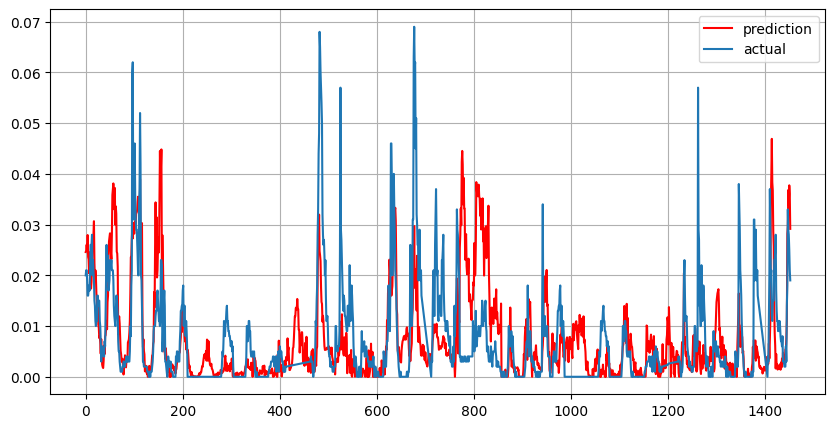

In [42]:
print('MAE =', mean_absolute_error(pred, y_test))
print()

plt.figure(figsize=(10, 5))
plt.plot(pred, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.show()

Модели улавливают большую часть тенденций. Можно еще улучшать точность.